In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import joblib
import matplotlib.pyplot as plt
import os
import numpy as np
import pandas as pd
import seaborn as sns
import glob

from tqdm.auto import tqdm
from calcium_imaging_analysis.analysis import proc_photoswitch
from calcium_imaging_analysis.fig import setup_plotting_env

1. Process directories
1. Process file by file
1. Finally, merge into parquet

## User functions

In [3]:
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit


def monoexp_decay(t, I0, tau, C=0):
    """
    Monoexponential decay function
    I(t) = I0 * exp(-t/tau) + C
    """
    return I0 * np.exp(-t / tau) + C


def fit_single_curve(time, intensity, include_offset=False):
    """
    Fit a single photobleaching curve to monoexponential decay

    Returns:
    dict with fit parameters and R^2
    """

    if include_offset:
        fit_func = monoexp_decay
        p0 = [intensity.iloc[0], time.mean(), intensity.min()]
        param_names = ["I0", "tau", "C"]
    else:
        fit_func = lambda t, I0, tau: monoexp_decay(t, I0, tau, C=0)
        p0 = [intensity.iloc[0], time.mean()]
        param_names = ["I0", "tau"]

    try:
        popt, pcov = curve_fit(fit_func, time, intensity, p0=p0, maxfev=2000)
        fitted = fit_func(time, *popt)

        # Calculate R^2
        ss_res = np.sum((intensity - fitted) ** 2)
        ss_tot = np.sum((intensity - intensity.mean()) ** 2)
        r_squared = 1 - (ss_res / ss_tot)

        # Parameter errors
        param_errors = np.sqrt(np.diag(pcov))

        results = {"r_squared": r_squared, "success": True}

        # Add parameters
        for name, value, error in zip(param_names, popt, param_errors):
            results[name] = value
            results[f"{name}_error"] = error

    except Exception as e:
        results = {"r_squared": None, "success": False, "error": str(e)}

        # Add None values for parameters
        for name in param_names:
            results[name] = None
            results[f"{name}_error"] = None

    return results


def analyze_photobleaching_data(
    df, biosensor_col="biosensor", cell_col="cell_id", time_col="time", intensity_col="intensity", include_offset=False
):
    """
    Analyze photobleaching data from long-form dataframe

    Parameters:
    df: pandas DataFrame with columns for biosensor, cell_id, time, intensity
    biosensor_col: name of biosensor column
    cell_col: name of cell ID column
    time_col: name of time column
    intensity_col: name of intensity column
    include_offset: whether to include background offset C in fit

    Returns:
    tuple: (individual_results_df, summary_stats_df)
    """

    individual_results = []

    # Group by biosensor and cell
    for (biosensor, cell_id), group in tqdm(df.groupby([biosensor_col, cell_col])):
        # Sort by time to ensure proper order
        group = group.sort_values(time_col)

        time = group[time_col].values
        intensity = group[intensity_col].values

        # Fit the curve
        fit_result = fit_single_curve(pd.Series(time), pd.Series(intensity), include_offset)

        # Store results
        row = {"biosensor": biosensor, "cell_id": cell_id, "n_timepoints": len(time), **fit_result}

        individual_results.append(row)

    individual_df = pd.DataFrame(individual_results)

    # Calculate summary statistics per biosensor
    summary_stats = []

    for biosensor in individual_df["biosensor"].unique():
        biosensor_data = individual_df[individual_df["biosensor"] == biosensor]
        successful_fits = biosensor_data[biosensor_data["success"] == True]

        if len(successful_fits) > 0:
            r2_values = successful_fits["r_squared"].dropna()
            tau_values = successful_fits["tau"].dropna()

            summary = {
                "biosensor": biosensor,
                "n_cells": len(biosensor_data),
                "n_successful_fits": len(successful_fits),
                "success_rate": len(successful_fits) / len(biosensor_data),
                # R² statistics
                "r2_mean": r2_values.mean(),
                "r2_std": r2_values.std(),
                "r2_median": r2_values.median(),
                "r2_min": r2_values.min(),
                "r2_max": r2_values.max(),
                # Tau statistics
                "tau_mean": tau_values.mean(),
                "tau_std": tau_values.std(),
                "tau_median": tau_values.median(),
                # Quality metrics
                "excellent_fits": (r2_values > 0.95).sum(),
                "good_fits": ((r2_values > 0.90) & (r2_values <= 0.95)).sum(),
                "poor_fits": (r2_values <= 0.90).sum(),
                "fraction_excellent": (r2_values > 0.95).mean(),
                "fraction_good_or_better": (r2_values > 0.90).mean(),
            }
        else:
            summary = {
                "biosensor": biosensor,
                "n_cells": len(biosensor_data),
                "n_successful_fits": 0,
                "success_rate": 0.0,
                "r2_mean": None,
                "r2_std": None,
                "r2_median": None,
                "r2_min": None,
                "r2_max": None,
                "tau_mean": None,
                "tau_std": None,
                "tau_median": None,
                "excellent_fits": 0,
                "good_fits": 0,
                "poor_fits": 0,
                "fraction_excellent": 0.0,
                "fraction_good_or_better": 0.0,
            }

        summary_stats.append(summary)

    summary_df = pd.DataFrame(summary_stats)

    return individual_df, summary_df

In [4]:
stim_points = [90, 150, 210, 270, 330]
mask_len = 40
# censor_points = 70

stim_mask = []
for _point in stim_points:
    stim_mask += list(range(_point - 5, _point + mask_len))
stim_mask = np.array(stim_mask)

In [5]:
def pad_series(s, window=100, center=True, method="reflect"):
    n = len(s)
    half = window // 2 if center else window - 1

    # Padding method: 'reflect', 'nearest', or 'constant'
    if method == "reflect":
        pad_left = s.iloc[1 : half + 1][::-1]
        pad_right = s.iloc[-half - 1 : -1][::-1]
    elif method == "nearest":
        pad_left = pd.Series([s.iloc[0]] * half)
        pad_right = pd.Series([s.iloc[-1]] * half)
    elif method == "constant":
        pad_left = pd.Series([0] * half)
        pad_right = pd.Series([0] * half)
    else:
        raise ValueError("Unsupported method")

    padded = pd.concat([pad_left, s, pad_right], ignore_index=True)
    return padded

In [6]:
def fit_and_subtract(y, window=100):
    y_mask = y.copy()
    use_stim_mask = stim_mask[stim_mask < len(y)]
    y_mask.iloc[use_stim_mask] = np.nan
    y_mask = y_mask.interpolate(method="linear")
    # print(y_mask.isnull().sum())
    y_mask = pad_series(y_mask, window=window, center=True, method="nearest")
    new_baseline = y_mask.rolling(window, center=True).median().iloc[window // 2 : -window // 2]
    return pd.Series(data=((y.values - new_baseline.values) / new_baseline.values), index=y.index)

In [8]:
# setup_plotting_env()
fig_dir = "/storage/home/hcoda1/4/jmarkowitz30/shared_folder/active_lab_members/markowitz_jeffrey/panels/2025-05 (ScarCaMP paper)/"
os.makedirs(fig_dir, exist_ok=True)

# Photoswitching plots

In [9]:

df_save_fname = os.path.join("/storage/home/hcoda1/4/jmarkowitz30/shared_folder/active_lab_members/markowitz_jeffrey/active_projects/red_calcium_screen/for_paper/invitro_results/photoswitching_df.parquet")

In [10]:
# WE ONLY NEED THIS TO REPEAT PRE-PROCESSING
# os.makedirs(os.path.dirname(df_save_fname), exist_ok=True)
# df_save_fname = os.path.join(base_dir, "_analysis", "photoswitching_df.parquet")
# os.makedirs(os.path.dirname(df_save_fname), exist_ok=True)

# output_fig_dir = os.path.join(base_dir, "_figs")
# os.makedirs(output_fig_dir, exist_ok=True)

# proc_data = sorted(glob.glob(os.path.join(base_dir, "**", "*.p"), recursive=True))
# proc_data = [os.path.normpath(_img) for _img in proc_data]

# data_channel = ["mCherry", "mCherry1", "TxRed (Photoswitch)"]

In [11]:
force = False

In [12]:
if not os.path.exists(df_save_fname) or force:
    delays = [
        joblib.delayed(proc_photoswitch)(_proc, data_channel=data_channel, output_fig_dir=output_fig_dir, force=False)
        for _proc in proc_data
    ]
    print(len(delays))
    results = joblib.Parallel(n_jobs=8, verbose=20)(delays)
    photoswitching_traces_df = pd.concat(results)
    photoswitching_traces_df.to_parquet(df_save_fname)
else:
    photoswitching_traces_df = pd.read_parquet(df_save_fname)

In [13]:
photoswitching_traces_df.index = range(len(photoswitching_traces_df))
photoswitching_traces_df["date_string"] = photoswitching_traces_df["filename"].str.extract(r"([0-9]+\-[0-9]+\-[0-9]+)")

In [14]:
# MAKE SURE NO ONE SATURATES!!!
photoswitching_traces_df = photoswitching_traces_df.groupby(["date_string","well","roi"]).filter(lambda x: (x["value"].max() < 2500).all()).copy()

In [15]:
# photoswitching_traces_df = photoswitching_traces_df.loc[pd.to_datetime(photoswitching_traces_df["date_string"]) > pd.to_datetime("2025-07-01")]

In [16]:
photoswitching_traces_df["has_cochr"] = photoswitching_traces_df["well"].str.lower().str.contains(
    "jm60"
) | photoswitching_traces_df["well"].str.lower().str.contains("cochr")

In [17]:
# photoswitching_traces_df["stim_duration"] = (
#     photoswitching_traces_df["well"].str.extract("(d)sec").fillna(5).astype("float")
# )
photoswitching_traces_df["stim_duration"] = 5
photoswitching_traces_df.loc[
    (
        photoswitching_traces_df["filename"].str.contains("1sec")
        & (pd.to_datetime(photoswitching_traces_df["date_string"]) > pd.to_datetime("2025-07-01"))
    ),
    "stim_duration",
] = 1
photoswitching_traces_df.loc[photoswitching_traces_df["date_string"] == "2025-07-29", "stim_duration"] = 1
photoswitching_traces_df["wavelength"] = (
    photoswitching_traces_df["well"].str.extract(r"(\d+)nm").fillna(440).astype("float")
)

In [18]:
photoswitching_traces_df = photoswitching_traces_df.query("wavelength < 500").copy()

In [19]:
threshold = (
    photoswitching_traces_df.groupby(["date_string", "well", "wavelength", "stim_duration"])["value_aux"]
    .apply(lambda x: np.maximum(x.quantile(0.5), 75))
    .rename("value_aux_threshold")
)
photoswitching_traces_df = photoswitching_traces_df[photoswitching_traces_df.columns.difference([threshold.name])]
photoswitching_traces_df = photoswitching_traces_df.merge(threshold, on=["date_string", "well"])
photoswitching_traces_df["has_cochr_in_well"] = (
    photoswitching_traces_df["value_aux"] > photoswitching_traces_df["value_aux_threshold"]
)

# Baseline correct and plot

In [20]:
# plt.style.use("dark_background")
plt.style.use("default")

In [21]:
tqdm.pandas()

In [22]:
detrend = photoswitching_traces_df.groupby(["date_string", "well", "roi"])[["frame_number", "value"]].progress_apply(
    lambda x: fit_and_subtract(x["value"], window=70)
)

new_idx = detrend.index.get_level_values(-1)
detrend.index = new_idx
# detrend = detrend.rename("value_dff0_corrected")
photoswitching_traces_df["value_dff0_corrected"] = detrend

  0%|          | 0/12263 [00:00<?, ?it/s]

In [23]:
include_dates = [
    "2024-11-13",
    "2024-11-14",
    "2025-07-29",   
    "2025-08-05",
]

In [24]:
plt.style.use("default")

In [25]:
stim_positions = [90, 150, 210, 270, 330]

In [26]:
setup_plotting_env()

In [27]:
# color1 = "tab:red"
# color2 = "tab:blue"
color1 = "r"
color2 = "b"

In [28]:
plt_order = ["jrgeco1a", "pinkycamp", "jrcamp1a", "jrcamp1b", "scarcamp"]

In [29]:
kwargs = {
    "height": 1.05,
    "aspect": 1.3,
    "row": "well_sanitized",
    "row_order": plt_order,
    "col": "wavelength",
    "col_order": [440.0, 488.0],
    "err_kws": {"alpha": 0.4},
    "alpha": 0.75,
    "palette": {True: color1, False: color2},
    "hue": "has_cochr",
    "kind": "line",
    "facet_kws": {"sharey": "row", "margin_titles": True},
    "errorbar": ("ci", 95),
}

In [30]:
name_map = {
    "jm26": "jrcamp1a",
    "jm27": "jrgeco1a",
    "jm28": "jrcamp1b",
    "jm56": "scarcamp",
    "jm88": "pinkycamp",
}

In [31]:
for k, v in name_map.items():
    photoswitching_traces_df["well_sanitized"] = photoswitching_traces_df["well_sanitized"].replace(k, v)

In [32]:
setup_plotting_env()

In [33]:
ylims = {
    "jrgeco1a": (-0.025, 0.7),
    "scarcamp": (-0.025, 0.15),
    "jrcamp1b": (-0.025, 0.2),
    "jrcamp1a": (-0.025, 0.4),
}

In [34]:
use_duration = 1

In [35]:
include_condition = photoswitching_traces_df.query(
    "(has_cochr and has_cochr_in_well and (stim_duration == @use_duration)) or (not has_cochr and (stim_duration == @use_duration))"
).index

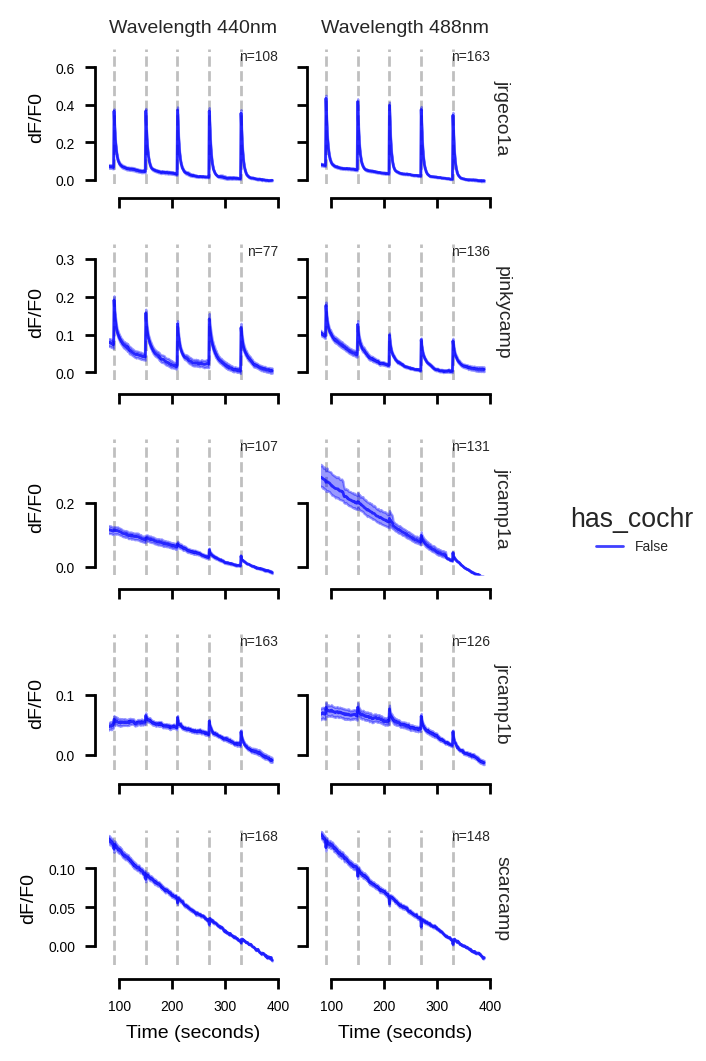

In [36]:
# fig, ax = plt.subplots(1, figsize=(2,2))
g = sns.relplot(
    photoswitching_traces_df.loc[include_condition].query("date_string.isin(@include_dates)"),
    x="frame_number",
    y="value_dff0",
    hue_order=[False],
    **kwargs,
)
g.set(ylabel="dF/F0", xlabel="Time (seconds)", xlim=(80, 400), xticks=range(100, 410, 100))
g.set_titles(row_template="{row_name}", col_template="Wavelength {col_name:g}nm")
for ax in g.axes.ravel():
    for _pos in stim_positions:
        ax.axvline(x=_pos, zorder=-300, alpha=0.25, color="k", ls="--")


def relabel_y(data, color=None):
    ax = plt.gca()
    nrois = len(data[["date_string","roi"]].drop_duplicates())
    ylims = ax.get_ylim()
    xlims = ax.get_xlim()
    xrange = xlims[1] - xlims[0]
    yrange = ylims[1] - ylims[0]
    xpos = xlims[1]
    ypos = ylims[1]
    ax.text(xpos, ypos, f"n={nrois}", ha="right", va="top", fontsize=5)


for _ax, _sensor in zip(g.axes, kwargs["row_order"]):
    try:
        _ax[0].set_ylim(ylims[_sensor])
    except KeyError:
        pass
g.map_dataframe(relabel_y)
sns.despine(offset=5, trim=True)
g.fig.savefig(
    os.path.join(fig_dir, f"hek_cell_optoresponses_raw_dff0_baseline_only-{use_duration}s.pdf"),
    dpi=600,
    bbox_inches="tight",
)

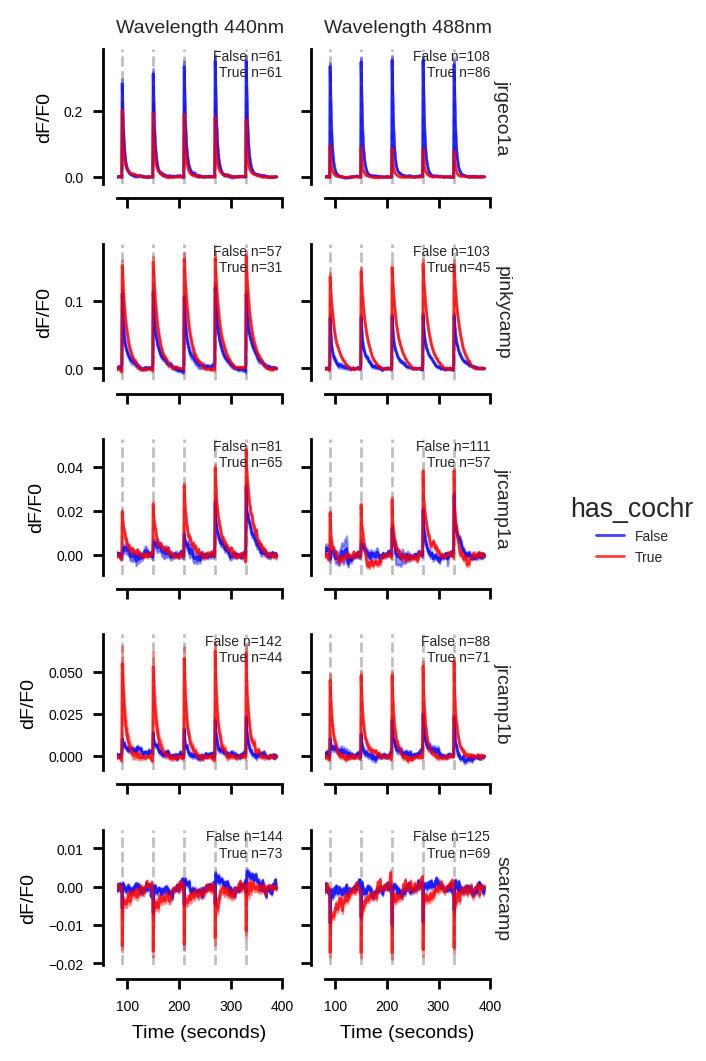

In [37]:
# fig, ax = plt.subplots(1, figsize=(2,2))
g = sns.relplot(
    photoswitching_traces_df.loc[include_condition].query("date_string.isin(@include_dates)"),
    x="frame_number",
    y="value_dff0_corrected",
    **kwargs,
)
g.set(ylabel="dF/F0", xlabel="Time (seconds)", xlim=(80, 400), xticks=range(100, 410, 100))
g.set_titles(row_template="{row_name}", col_template="Wavelength {col_name:g}nm")
for ax in g.axes.ravel():
    for _pos in stim_positions:
        ax.axvline(x=_pos, zorder=-300, alpha=0.25, color="k", ls="--")


def relabel_y(data, color=None):
    ax = plt.gca()
    nrois = data.groupby(["date_string", "has_cochr"])["roi"].nunique()
    nrois = nrois.groupby("has_cochr").sum()

    show_text = ""
    for k, v in nrois.items():
        show_text += f"{k} n={v}\n"

    ylims = ax.get_ylim()
    xlims = ax.get_xlim()
    xrange = xlims[1] - xlims[0]
    yrange = ylims[1] - ylims[0]
    xpos = xlims[1]
    ypos = ylims[1]
    ax.text(xpos, ypos, show_text, ha="right", va="top", fontsize=5)


g.map_dataframe(relabel_y)
sns.despine(offset=5, trim=False)
g.fig.savefig(os.path.join(fig_dir, f"hek_cell_optoresponses-{use_duration}s.pdf"), dpi=600, bbox_inches="tight")

In [38]:
include_condition = photoswitching_traces_df.query(
    "(has_cochr and has_cochr_in_well and (stim_duration > 0)) or (not has_cochr and (stim_duration > 0))"
).index

In [39]:
group_keys = ["date_string", "well", "well_sanitized", "has_cochr", "roi", "wavelength", "stim_duration"]

In [40]:
responses = []
for i, _pos in tqdm(enumerate(stim_positions), total=len(stim_positions)):
    new_key = f"stim_{i}"
    _pos_left = _pos - 0
    _pos_right = _pos + 15
    response = (
        photoswitching_traces_df.loc[include_condition]
        .query("frame_number.between(@_pos_left, @_pos_right)")
        .groupby(group_keys)["value_dff0_corrected"]
        .agg(max_response=lambda x: x.abs().max(), mean_response=lambda x: x.abs().mean())
    )
    response["stim_number"] = i
    responses.append(response)
    # photoswitching_traces_df = photoswitching_traces_df[photoswitching_traces_df.columns.difference([response.name])]
    # photoswitching_traces_df = pd.merge(photoswitching_traces_df, response, on=group_keys)

  0%|          | 0/5 [00:00<?, ?it/s]

In [41]:
response_df = pd.concat(responses).reset_index()

In [42]:
ave_peak_response = (
    response_df.query("has_cochr")
    .groupby(["date_string", "wavelength", "well_sanitized", "stim_number"])["max_response"]
    .mean()
)
photoswitch_df = (
    response_df.query("not has_cochr")
    .groupby(["date_string", "well_sanitized", "stim_number", "stim_duration", "wavelength", "roi"])[
        ["mean_response", "max_response"]
    ]
    .mean()
)
photoswitch_df = photoswitch_df.join(ave_peak_response.rename("peak_ca"))

In [43]:
photoswitch_df["mean_response_frac"] = (photoswitch_df["mean_response"] / photoswitch_df["peak_ca"]) * 100
photoswitch_df["max_response_frac"] = (photoswitch_df["max_response"] / photoswitch_df["peak_ca"]) * 100
photoswitch_df["mean_response"] = photoswitch_df["mean_response"]
photoswitch_df["max_response"] = photoswitch_df["max_response"]

In [44]:
plt_photoswitch_df = photoswitch_df.melt(ignore_index=False).reset_index()

In [45]:
# NEED TO DOUBLE CHECK THESE NUMBERS!
power = {
    "x": [1, 2, 3, 4, 5, 8, 10, 16, 25, 50, 75, 100],
    "488": [
        7.39,
        7.5,
        7.88,
        10.34,
        12.56,
        19.72,
        23.5,
        36.3,
        54.9,
        106.9,
        158.2,
        207.8,
    ],
    "440": [
        5.61,
        5.79,
        7.33,
        9.36,
        11.76,
        17.49,
        21.82,
        33.9,
        51.9,
        101.8,
        151.2,
        199.4,
    ],
}

In [46]:
power_df = pd.DataFrame(power).set_index("x")

In [47]:
power_df = power_df.reindex(np.arange(100)).interpolate()

In [48]:
spot_radius = 0.233 # originally 0.216 mm
spot_area = np.pi * (spot_radius ** 2)
power_df = (power_df / spot_area).round(1)

In [49]:
# 1, 2, 4, 8, 16 percent
percentages = [1, 2, 4, 8, 16]
mapper_488 = {i: power_df.loc[_percent, "488"] for i, _percent in enumerate(percentages)}
mapper_440 = {i: power_df.loc[_percent, "440"] for i, _percent in enumerate(percentages)}

In [50]:
power_488 = plt_photoswitch_df.loc[plt_photoswitch_df["wavelength"] == 488, "stim_number"].map(mapper_488)
power_440 = plt_photoswitch_df.loc[plt_photoswitch_df["wavelength"] == 440, "stim_number"].map(mapper_440)

In [51]:
power_440.unique()

array([ 32.9,  33.9,  54.9, 102.5, 198.8])

In [52]:
power_488.unique()

array([ 43.3,  44. ,  60.6, 115.6, 212.8])

In [53]:
plt_photoswitch_df["mw_per_mmsq"] = pd.concat([power_440,power_488]).sort_index()

In [54]:
sns.set_context("paper", font_scale=0.75)

In [55]:
setup_plotting_env()

In [56]:
for k, v in name_map.items():
    plt_photoswitch_df["well_sanitized"] = plt_photoswitch_df["well_sanitized"].replace(k, v)

In [57]:
use_palette = sns.color_palette("Blues", n_colors=6)[1:]

In [58]:
npulses = plt_photoswitch_df["stim_number"].nunique()

/tmp/ipykernel_3479262/998828604.py:64: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  g.axes.ravel()[-1].set_xticklabels(g.axes.ravel()[-1].get_xticklabels(), rotation=25, ha="right")


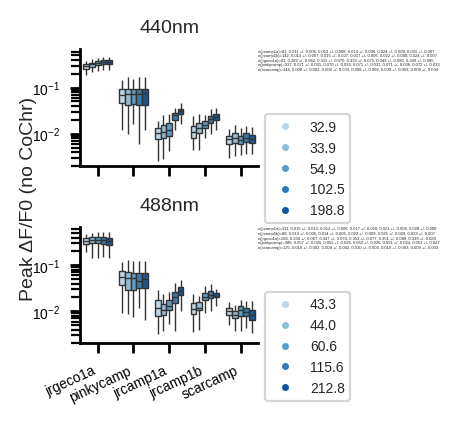

In [59]:
g = sns.catplot(
    data=plt_photoswitch_df.query("variable == 'max_response' and stim_duration == @use_duration"),
    x="well_sanitized",
    order=plt_order,
    hue="stim_number",
    y="value",
    row_order=[440.0, 488.0],
    row="wavelength",
    sharey=True,
    palette=use_palette,
    height=1.0,
    aspect=2.25,
    kind="box",
    showfliers=False,
    showcaps=False,
    linewidth=.5,
    # boxprops={"edgecolor": None},
    # kind="strip",
    # size=1.5,
    # alpha=0.15,
    legend=False,
    # dodge=True,
)
plt.yscale("log")


def relabel_y(data, color=None):
    ax = plt.gca()
    nrois = data.groupby(["date_string", "well_sanitized"])["roi"].nunique()
    nrois = nrois.groupby("well_sanitized").sum()

    # also let's show mean +/- SD
    mu = data.groupby(["well_sanitized","stim_number"])["value"].mean()
    sd = data.groupby(["well_sanitized","stim_number"])["value"].std()

    show_text = ""

    for _sensor, _nrois in nrois.items():
        if _sensor in plt_order:
            show_text += f"n({_sensor})={_nrois}" 
            for _pulse in range(npulses): 
                show_text += f", {mu[_sensor,_pulse]:.3f} +/- {sd[_sensor,_pulse]:.3f}"
            show_text +="\n"

    ylims = ax.get_ylim()
    xlims = ax.get_xlim()
    xrange = xlims[1] - xlims[0]
    yrange = ylims[1] - ylims[0]
    xpos = xlims[1]
    ypos = ylims[1]
    ax.text(xpos, ypos, show_text, ha="left", va="top", fontsize=1.5)

    # xpos = xlims[1] - xrange / 2
    # ypos = ylims[1] - yrange / 10
    # title = ax.get_title()
    # ax.text(xpos, ypos, title, ha="left", va="center", fontsize=7)
    # ax.set_title("")


g.set_titles(row_template="{row_name:g}nm")
g.set(xlabel="", ylabel="")
g.map_dataframe(relabel_y)
g.fig.supylabel("Peak ΔF/F0 (no CoChr)", fontsize=7)
g.axes.ravel()[-1].set_xticklabels(g.axes.ravel()[-1].get_xticklabels(), rotation=25, ha="right")


for _ax, _wavelength in zip(g.axes.ravel(), [440., 488.]):
    data = plt_photoswitch_df.query("wavelength == @_wavelength") 
    custom_labels = sorted(data["mw_per_mmsq"].unique())
    custom_handles = [
        plt.matplotlib.lines.Line2D([], [], marker="o", color=c, linestyle="none", markerfacecolor=c, markersize=1.5, label=l)
        for c, l in zip(use_palette, custom_labels)
    ]
    l = _ax.legend(handles=custom_handles, bbox_to_anchor=(1, .5), prop={'size': 5})
    
g.fig.savefig(
    os.path.join(fig_dir, f"hek_cell_photoswitch_max_log-{use_duration}s.pdf"), dpi=600, bbox_inches="tight"
)